In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn

In [2]:
transformation_operation = transforms.Compose([transforms.ToTensor()])

In [3]:
train_dataset = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transformation_operation)
val_dataset = torchvision.datasets.MNIST(root = './data', train = False,download = True,transform = transformation_operation)


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 344kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.21MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.37MB/s]


In [4]:
num_classes = 10
batch_size =64
num_channels = 1
image_size = 28
patch_size = 7
num_patches = (image_size//patch_size)**2
embedding_dim = 64
attention_heads = 4
transformer_blocks = 4
mlp_hidden_nodes = 128
learning_rate = 0.001
epochs = 5

In [8]:
# Defining dataset batches
train_loader = DataLoader(train_dataset, batch_size = batch_size,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size = batch_size,shuffle=True)

In [16]:
class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = nn.Conv2d(num_channels,embedding_dim,kernel_size = patch_size,stride = patch_size)

    def forward(self,x):
        x = self.patch_embed(x)
        x = x.flatten(2)
        x = x.transpose(1,2) #(64,16,64)
        return x

In [28]:
class TransformerEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)
        self.Multihead_atten = nn.MultiheadAttention(embedding_dim,attention_heads,batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim,mlp_hidden_nodes),
            nn.GELU(),
            nn.Linear(mlp_hidden_nodes,embedding_dim),
        )

    def forward(self,x):
        residual1 = x
        x = self.layer_norm1(x)
        x = self.Multihead_atten(x,x,x)[0]
        x = x + residual1
        residual2 = x
        x = self.layer_norm2(x)
        x = self.mlp(x)
        x = x + residual2
        return x

In [29]:
class Mlp_head(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.mlp_head = nn.Linear(embedding_dim,num_classes)

    def forward(self,x):
        x = self.layer_norm(x)
        x = self.mlp_head(x)
        return x
        

In [30]:
class VisionTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embedding = PatchEmbedding()
        self.class_token = nn.Parameter(torch.randn(1,1,embedding_dim))
        self.position_embedding = nn.Parameter(torch.randn(1,num_patches+1,embedding_dim))
        self.transformer_block = nn.Sequential(*[TransformerEncoder() for _ in range(transformer_blocks)])
        self.mlp_head = Mlp_head()

    def forward(self,x):
        x = self.patch_embedding(x)
        B = x.size(0)
        class_tokens = self.class_token.expand(B,-1,-1)
        x = torch.cat((class_tokens,x),dim=1)
        x = x + self.position_embedding
        x = self.transformer_block(x)
        x = x[:,0] # take only class token
        x = self.mlp_head(x)
        return x
        

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [36]:
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    correct_epoch = 0
    total_epoch = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct_epoch += (preds == labels).sum().item()
        total_epoch += labels.size(0)
   
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = 100.0 * correct_epoch / total_epoch

    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")


Epoch 1/5 | Loss: 0.0702 | Accuracy: 97.76%
Epoch 2/5 | Loss: 0.0562 | Accuracy: 98.22%
Epoch 3/5 | Loss: 0.0525 | Accuracy: 98.30%
Epoch 4/5 | Loss: 0.0460 | Accuracy: 98.50%
Epoch 5/5 | Loss: 0.0396 | Accuracy: 98.69%


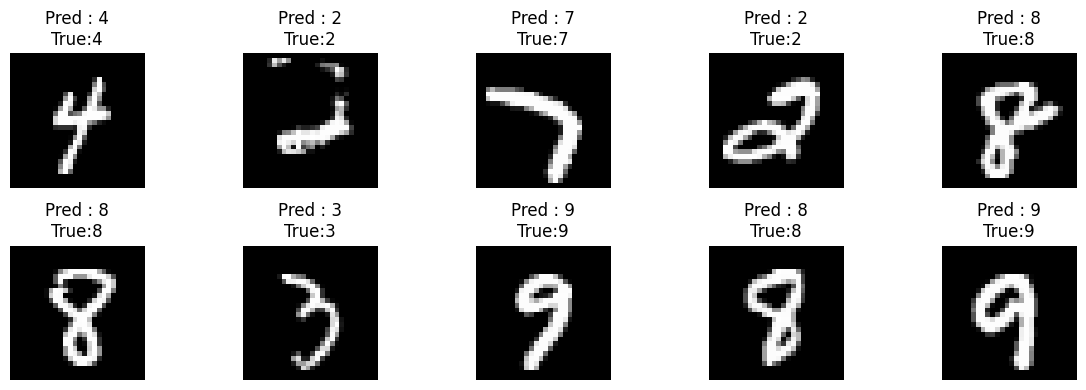

In [40]:
import matplotlib.pyplot as plt

model.eval()
images , labels = next(iter(val_loader))
images, labels = images.to(device),labels.to(device)
with torch.no_grad():
    output = model(images)
    preds = output.argmax(dim=1)


images = images.cpu()
preds = preds.cpu()
labels = labels.cpu()

plt.figure(figsize =(12,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i].squeeze(),cmap='gray')
    plt.title(f"Pred : {preds[i].item()}\nTrue:{labels[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()